In [1]:
import urllib,os
from netCDF4 import Dataset

download=False
the_file='case_60_10.nc'
the_url="http://clouds.eos.ubc.ca/~phil/docs/atsc500/data/{}".format(the_file)
if download:
    out=urllib.request.urlretrieve(the_url,the_file)
    print(out)
print("download {}: size is {:8.4g} Mbytes".format(the_file,os.path.getsize(the_file)*1.e-6))

download case_60_10.nc: size is    499.3 Mbytes


Netcdf file layout:  10 groups corresponding to 10 different ensemble members.  Small slice of larger domain of LES run with surface heat flux of 60 W/m^2 and stable layer with dT/dz = 10 K/km.  Snapshots every 10 minutes for 8 hours.

In [2]:
!ncdump -h case_60_10.nc

netcdf case_60_10 {
dimensions:
	time = 48 ;
	x = 25 ;
	y = 20 ;
	z = 130 ;
variables:
	float time(time) ;
		string time:units = "minutes" ;
	float x(x) ;
		string x:units = "meters" ;
	float y(y) ;
		string y:units = "meters" ;
	float z(z) ;
		string z:units = "meters" ;
	float press(z) ;
		string press:units = "Pa" ;

// global attributes:
		:heat_flux_W_m2 = 100L ;
		:gamma_K_km = 10L ;

group: c1 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c1

group: c2 {
  variables:
  	float TABS(time, z, y, x) ;
  		string TABS:units = "K" ;
  	float W(time, z, y, x) ;
  		string W:units = "m/s" ;
  	float U(time, z, y, x) ;
  		string U:units = "m/s" ;
  	float V(time, z, y, x) ;
  		string V:units = "m/s" ;
  } // group c2

group: c3 {
  variables:
  	float TABS(time, z, y, x) ;
  

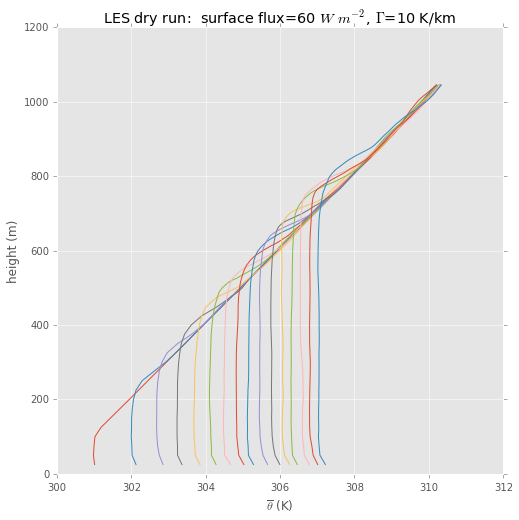

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def make_theta(temp,press):
    """
      temp in K
      press in Pa
      returns theta in K
    """
    p0=1.e5
    Rd=287.
    cpd=1004.
    theta=temp*(p0/press)**(Rd/cpd)
    
    return theta
    
case_name='case_60_10.nc'
ensemble='c1'
with Dataset(case_name,'r') as ncin:
    group = ncin.groups['c1']
    temp=group.variables['TABS'][...]
    press=ncin.variables['press'][...]
    z=ncin.variables['z'][...]
    w=group.variables['W'][...]
temp_mean=temp.mean(axis=3).mean(axis=2)
w_mean=w.mean(axis=3).mean(axis=2)

plt.close('all')
plt.style.use('ggplot')
fig,ax=plt.subplots(1,1,figsize=(8,8))
for i in np.arange(0,temp.shape[0],3):
    theta = make_theta(temp_mean[i,:],press)
    ax.plot(theta,z)
ax.set(xlabel=r'$\overline{\theta}$ (K)',ylabel='height (m)',
       title='LES dry run:  surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')

    

In [4]:
# grab ensemble members by looping through the group names
members = np.arange(1,11,1)
w_ensemble = np.empty([w.shape[0],w.shape[1],w.shape[2],w.shape[3],members.shape[0]])
temp_ensemble = np.empty_like(w_ensemble)
for i in range(members.shape[0]):
    ensemble = "c{}".format(members[i])
    with Dataset(case_name,'r') as ncin:
        group = ncin.groups[ensemble]
        temp_ensemble[:,:,:,:,i]=group.variables['TABS'][...]
        w_ensemble[:,:,:,:,i]=group.variables['W'][...]

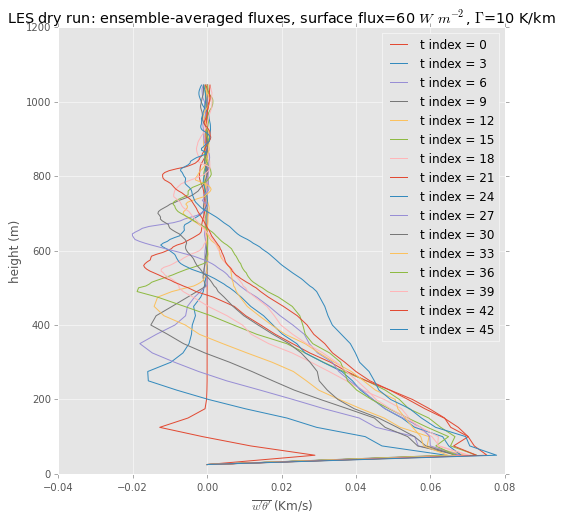

In [9]:
# now calculate fluxes, average along horizontal dimensions, then average across ensemble members
theta = np.empty_like(temp_ensemble)
theta_flux = np.empty_like(w_ensemble)

for i in range(0,temp_ensemble.shape[1]):
    theta[:,i,:,:,:] = make_theta(temp_ensemble[:,i,:,:,:],press[i]) # calculate thetas
    
    
theta_mean = theta.mean(axis=3).mean(axis=2)
w_mean = w_ensemble.mean(axis=3).mean(axis=2)


for i in range(0,w_ensemble.shape[0]): # calculate fluxes
    for j in range(0,w_ensemble.shape[1]):
        theta_flux[i,j,:,:,:] = (w_ensemble[i,j,:,:,:] - w_mean[i,j])*(theta[i,j,:,:] - theta_mean[i,j])
        
flux_means = theta_flux.mean(axis=3).mean(axis=2) # spatial averages

flux_ensemble = flux_means.mean(axis=2) # ensemble averages 

fig,ax=plt.subplots(1,1,figsize=(8,8))
for i in np.arange(0,flux_ensemble.shape[0],3):
    ax.plot(flux_ensemble[i,:],z,label="t index = {}".format(i))
    
ax.set(xlabel=r"$\overline{w'\theta'}$ (Km/s)",ylabel='height (m)',
       title='LES dry run: ensemble-averaged fluxes, surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')
ax.legend()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]


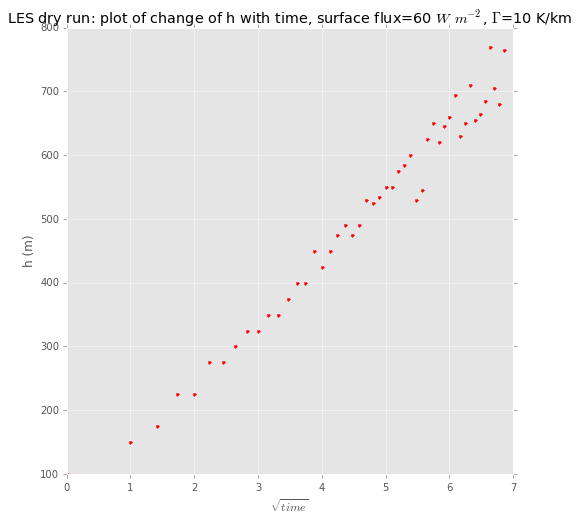

In [21]:
# find height of base of entrainment layer

times = np.arange(flux_ensemble.shape[0])
h = np.empty_like(times)
print(times)
              
for i in range(flux_ensemble.shape[0]):
    h[i] = z[(np.where(flux_ensemble[i,:] < 0)[0][0])] # find where indices go negative (take first one)

fig,ax=plt.subplots(1,1,figsize=(8,8))
# time is arranged linearly, so I can just use time index and take square root of that
ax.plot(np.sqrt(times),h, 'r.')
ax.set(xlabel=r"$\sqrt{time}$",ylabel='h (m)',
       title='LES dry run: plot of change of h with time, surface flux=60 $W\,m^{-2}$, $\Gamma$=10 K/km')

# plot clearly shows that h increases with sqrt(time), as predicted from 1.) 